In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from dataprep.eda import plot,plot_correlation,plot_missing,create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,cross_val_score,train_test_split,RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv("Company_Data.csv")
data.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  Education Urban   US
0   9.50        138      73           11         276    120       Bad   42         17   Yes  Yes
1  11.22        111      48           16         260     83      Good   65         10   Yes  Yes
2  10.06        113      35           10         269     80    Medium   59         12   Yes  Yes
3   7.40        117     100            4         466     97    Medium   55         14   Yes  Yes
4   4.15        141      64            3         340    128       Bad   38         13   Yes   No

In [7]:
data.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [8]:
data.isnull().any()

Sales          False
CompPrice      False
Income         False
Advertising    False
Population     False
Price          False
ShelveLoc      False
Age            False
Education      False
Urban          False
US             False
dtype: bool

In [9]:
data.shape

(400, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [11]:
data[data.duplicated()].shape

(0, 11)

In [12]:
data[data.duplicated()]

Empty DataFrame
Columns: [Sales, CompPrice, Income, Advertising, Population, Price, ShelveLoc, Age, Education, Urban, US]
Index: []

In [13]:
data.describe()

Sales   CompPrice      Income  Advertising  Population       Price         Age   Education
count  400.000000  400.000000  400.000000   400.000000  400.000000  400.000000  400.000000  400.000000
mean     7.496325  124.975000   68.657500     6.635000  264.840000  115.795000   53.322500   13.900000
std      2.824115   15.334512   27.986037     6.650364  147.376436   23.676664   16.200297    2.620528
min      0.000000   77.000000   21.000000     0.000000   10.000000   24.000000   25.000000   10.000000
25%      5.390000  115.000000   42.750000     0.000000  139.000000  100.000000   39.750000   12.000000
50%      7.490000  125.000000   69.000000     5.000000  272.000000  117.000000   54.500000   14.000000
75%      9.320000  135.000000   91.000000    12.000000  398.500000  131.000000   66.000000   16.000000
max     16.270000  175.000000  120.000000    29.000000  509.000000  191.000000   80.000000   18.000000

In [14]:
data.Sales.describe()

count    400.000000
mean       7.496325
std        2.824115
min        0.000000
25%        5.390000
50%        7.490000
75%        9.320000
max       16.270000
Name: Sales, dtype: float64

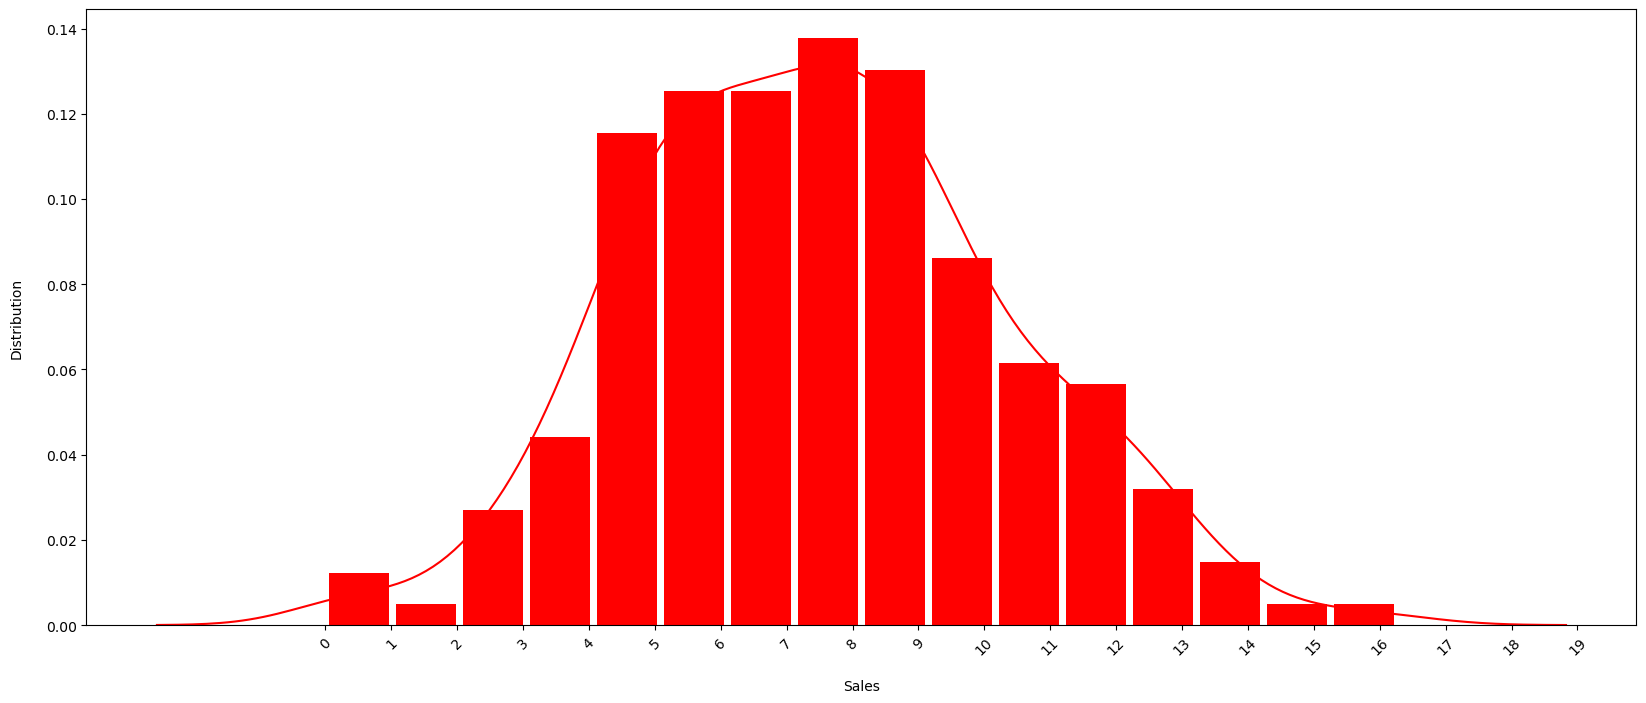

In [15]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(data[param],color = 'red' , hist_kws={"rwidth":0.90, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation = 45)
    plt.xlabel("\n"+param)
    plt.ylabel("Distribution\n")
    plt.show()  
distplot("Sales")

In [16]:
data.Sales.max()

16.27

In [17]:
16.27/3

5.423333333333333

In [18]:
5.423333333333333*2

10.846666666666666

In [19]:
5.423333333333333*3

16.27

In [20]:
#converting taxable_income <=30000 as "Risky" and others are "Good"
data1 = data.copy()
data1['Sales_cat'] = pd.cut(x = data1['Sales'],bins = [0,5.39,9.32,17],labels=['Low','Medium','High'],right = False)
data1.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  Education Urban   US Sales_cat
0   9.50        138      73           11         276    120       Bad   42         17   Yes  Yes      High
1  11.22        111      48           16         260     83      Good   65         10   Yes  Yes      High
2  10.06        113      35           10         269     80    Medium   59         12   Yes  Yes      High
3   7.40        117     100            4         466     97    Medium   55         14   Yes  Yes    Medium
4   4.15        141      64            3         340    128       Bad   38         13   Yes   No       Low

In [21]:
data1.Sales_cat.value_counts()

Medium    198
High      102
Low       100
Name: Sales_cat, dtype: int64

In [22]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    object  
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    object  
 10  US           400 non-null    object  
 11  Sales_cat    400 non-null    category
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 35.0+ KB


In [23]:
categorical_features = data1.describe(include=['object','category']).columns
categorical_features

Index(['ShelveLoc', 'Urban', 'US', 'Sales_cat'], dtype='object')

In [29]:
numerical_features = data1.describe(include = ['int64','float64']).columns
numerical_features

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'Age', 'Education'],
      dtype='object')

# Data Visualization

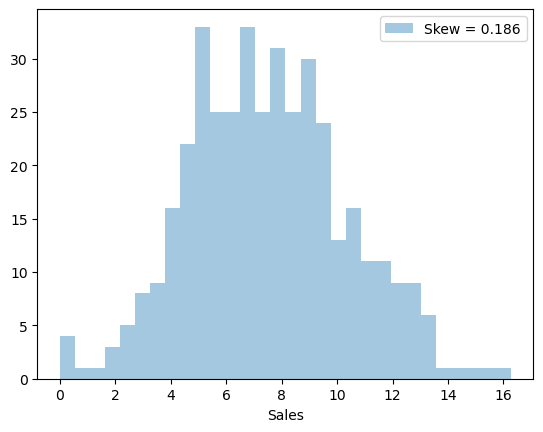

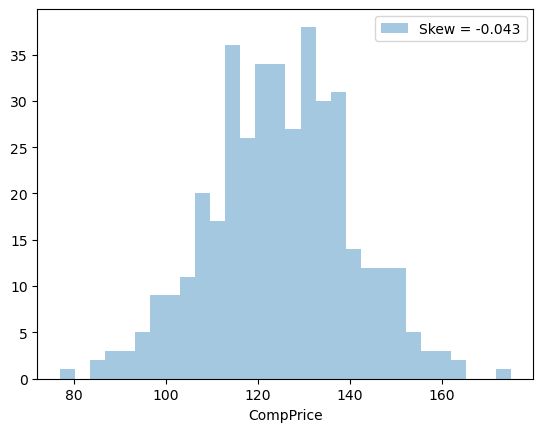

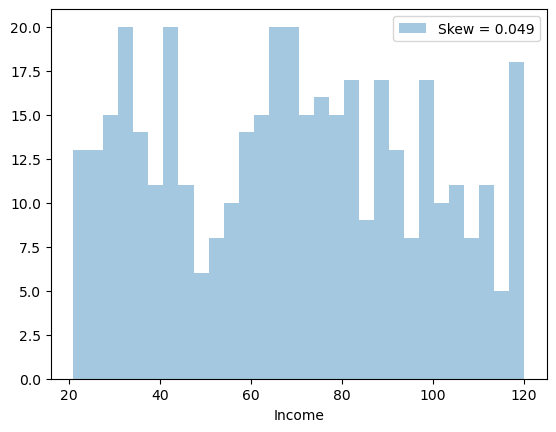

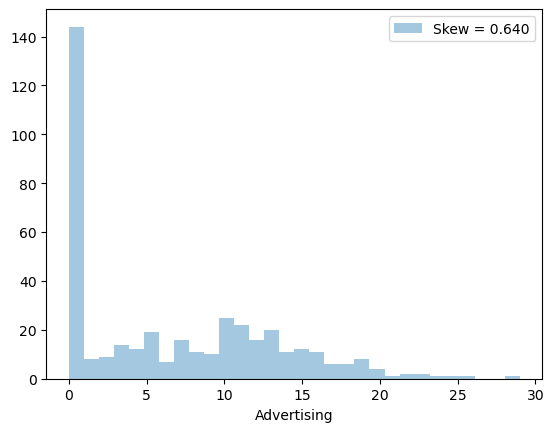

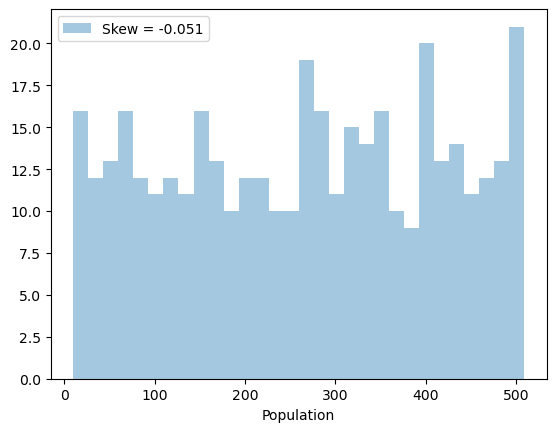

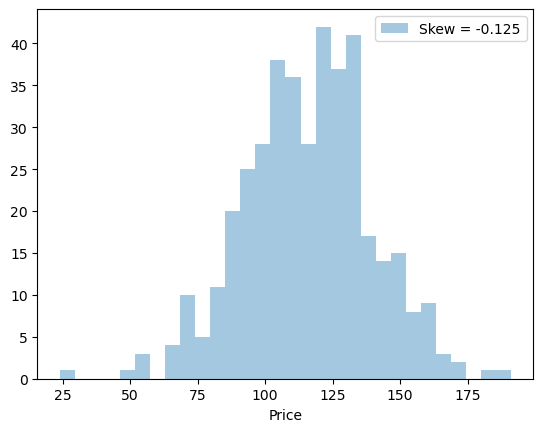

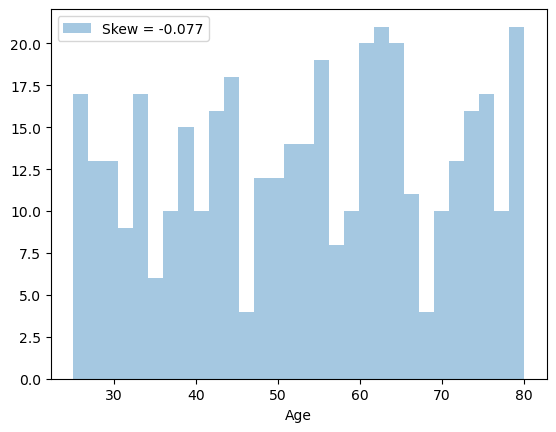

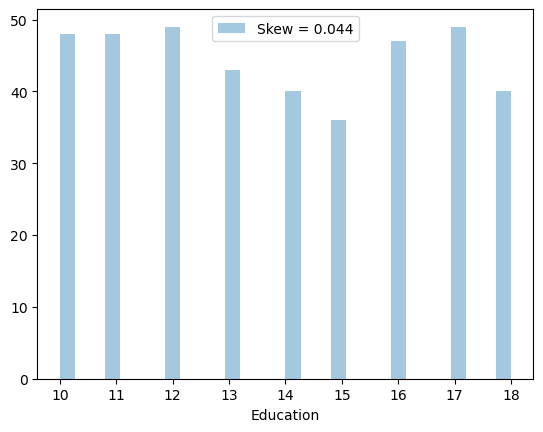

In [33]:
numerical_features = [feature for feature in data.columns if data[feature].dtypes != 'O']
for feat in numerical_features:
    skew = data[feat].skew()
    sns.distplot(data[feat],kde=False,label='Skew = %.3f' %(skew),bins = 30)
    plt.legend(loc='best')
    plt.show()
                      

In [34]:
#detect observations with more than one outlier

def outlier_hunt(data):
    outlier_indices=[]
    for col in data.columns.tolist():
        
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        
        IQR = Q3-Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] >Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)
        
    return multiple_outliers
print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(data[numerical_features]))))
    
            

The dataset contains 0 observations with more than 2 outliers


In [35]:
numerical_features

['Sales',
 'CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'Age',
 'Education']

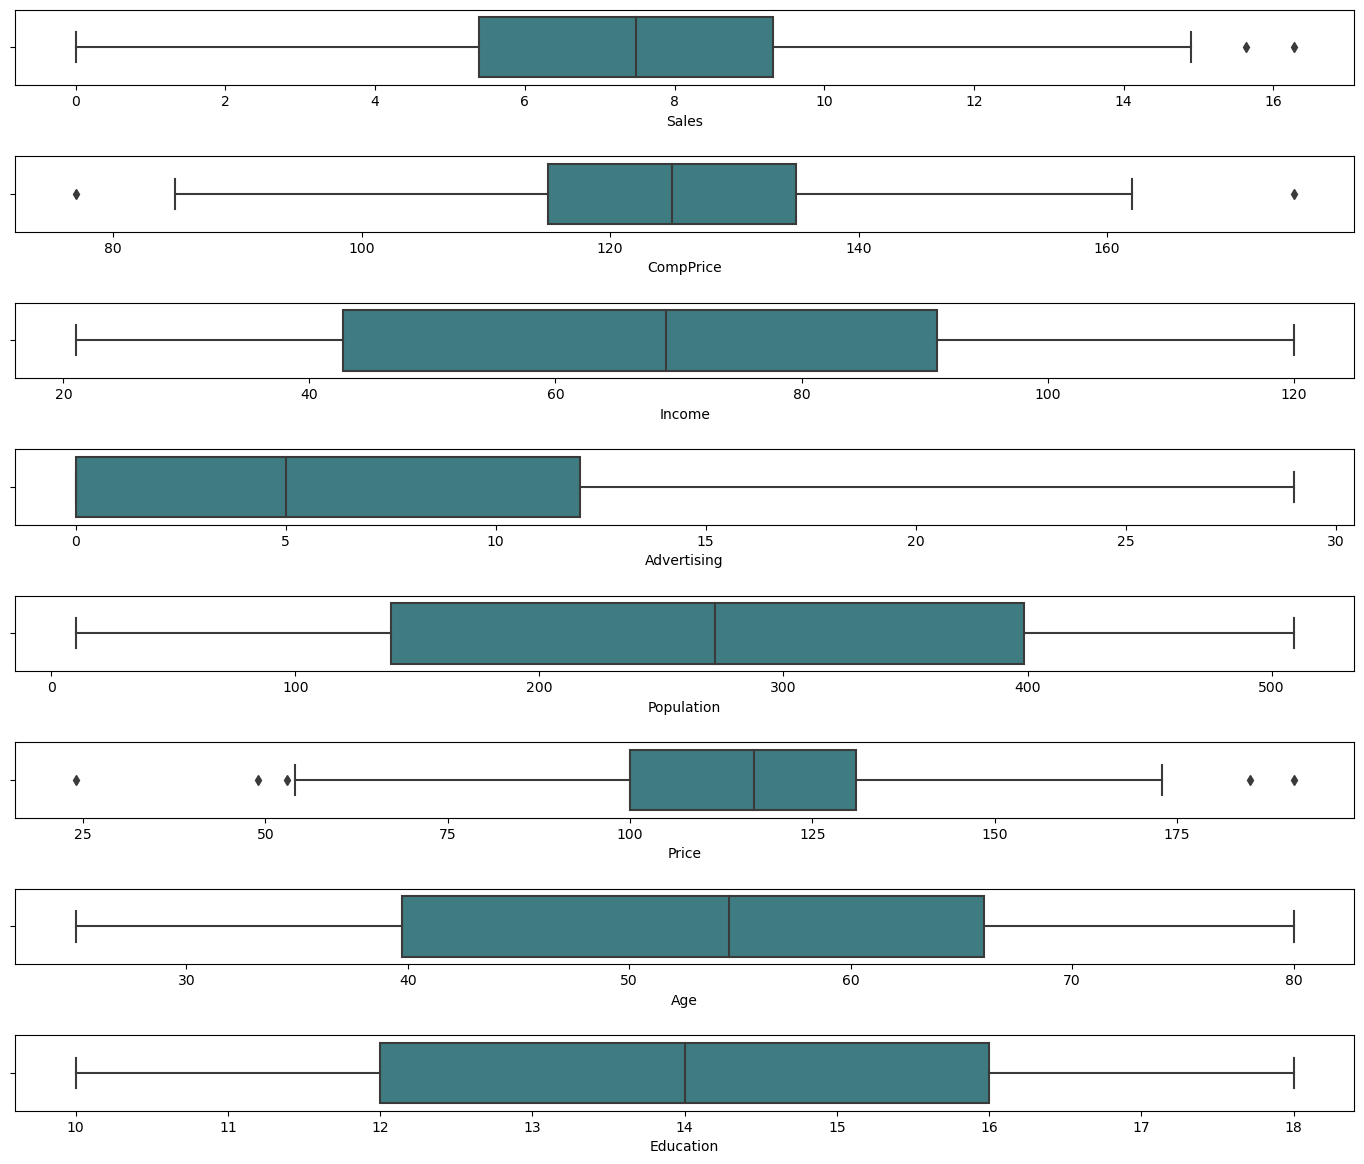

In [36]:
ot=data.copy() 
fig, axes=plt.subplots(8,1,figsize=(14,12),sharex=False,sharey=False)
sns.boxplot(x='Sales',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='CompPrice',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Income',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='Advertising',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='Population',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='Price',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Age',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Education',data=ot,palette='crest',ax=axes[7])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

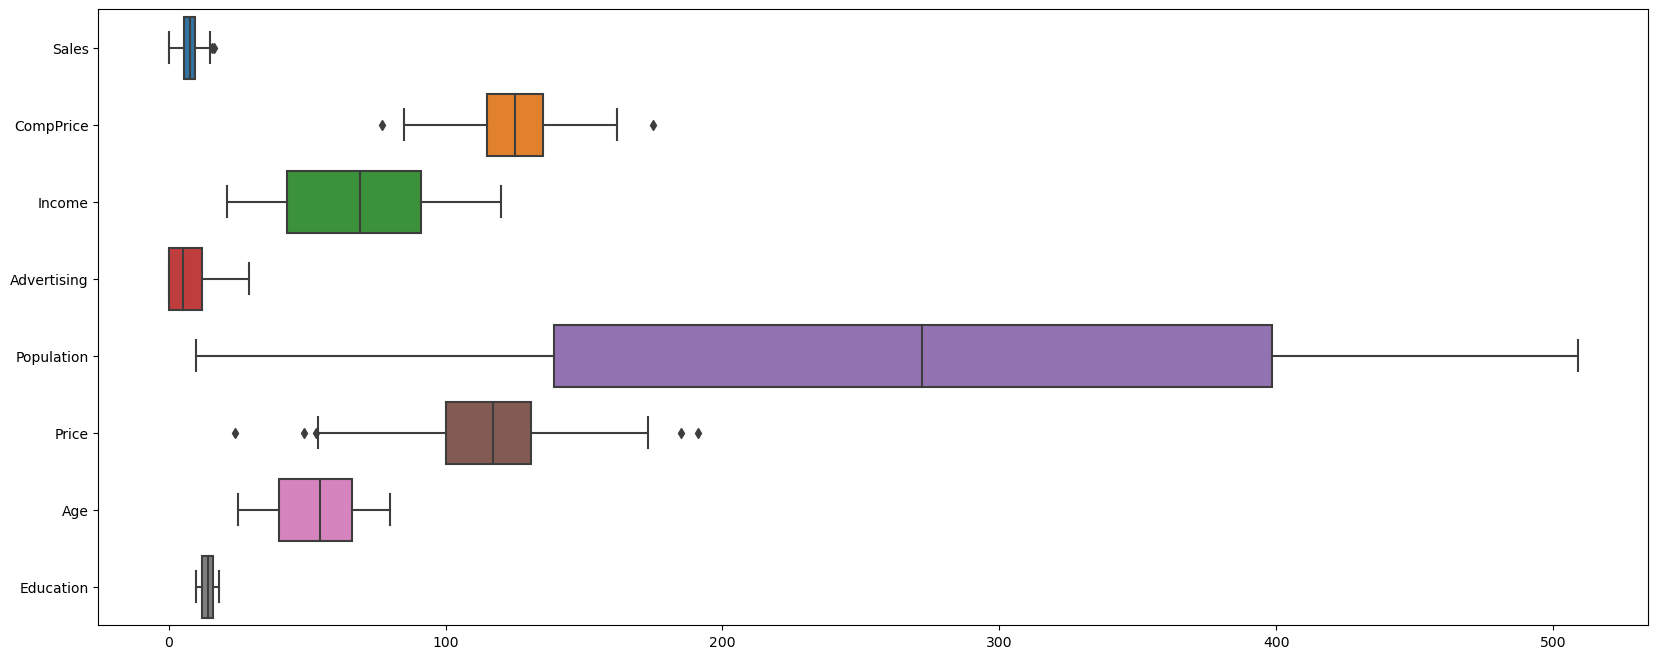

In [41]:
#outlier
plt.figure(figsize=(20,8))
sns.boxplot(data = data[numerical_features],orient='h')

# Multivariate Analysis

<Figure size 2000x800 with 0 Axes>

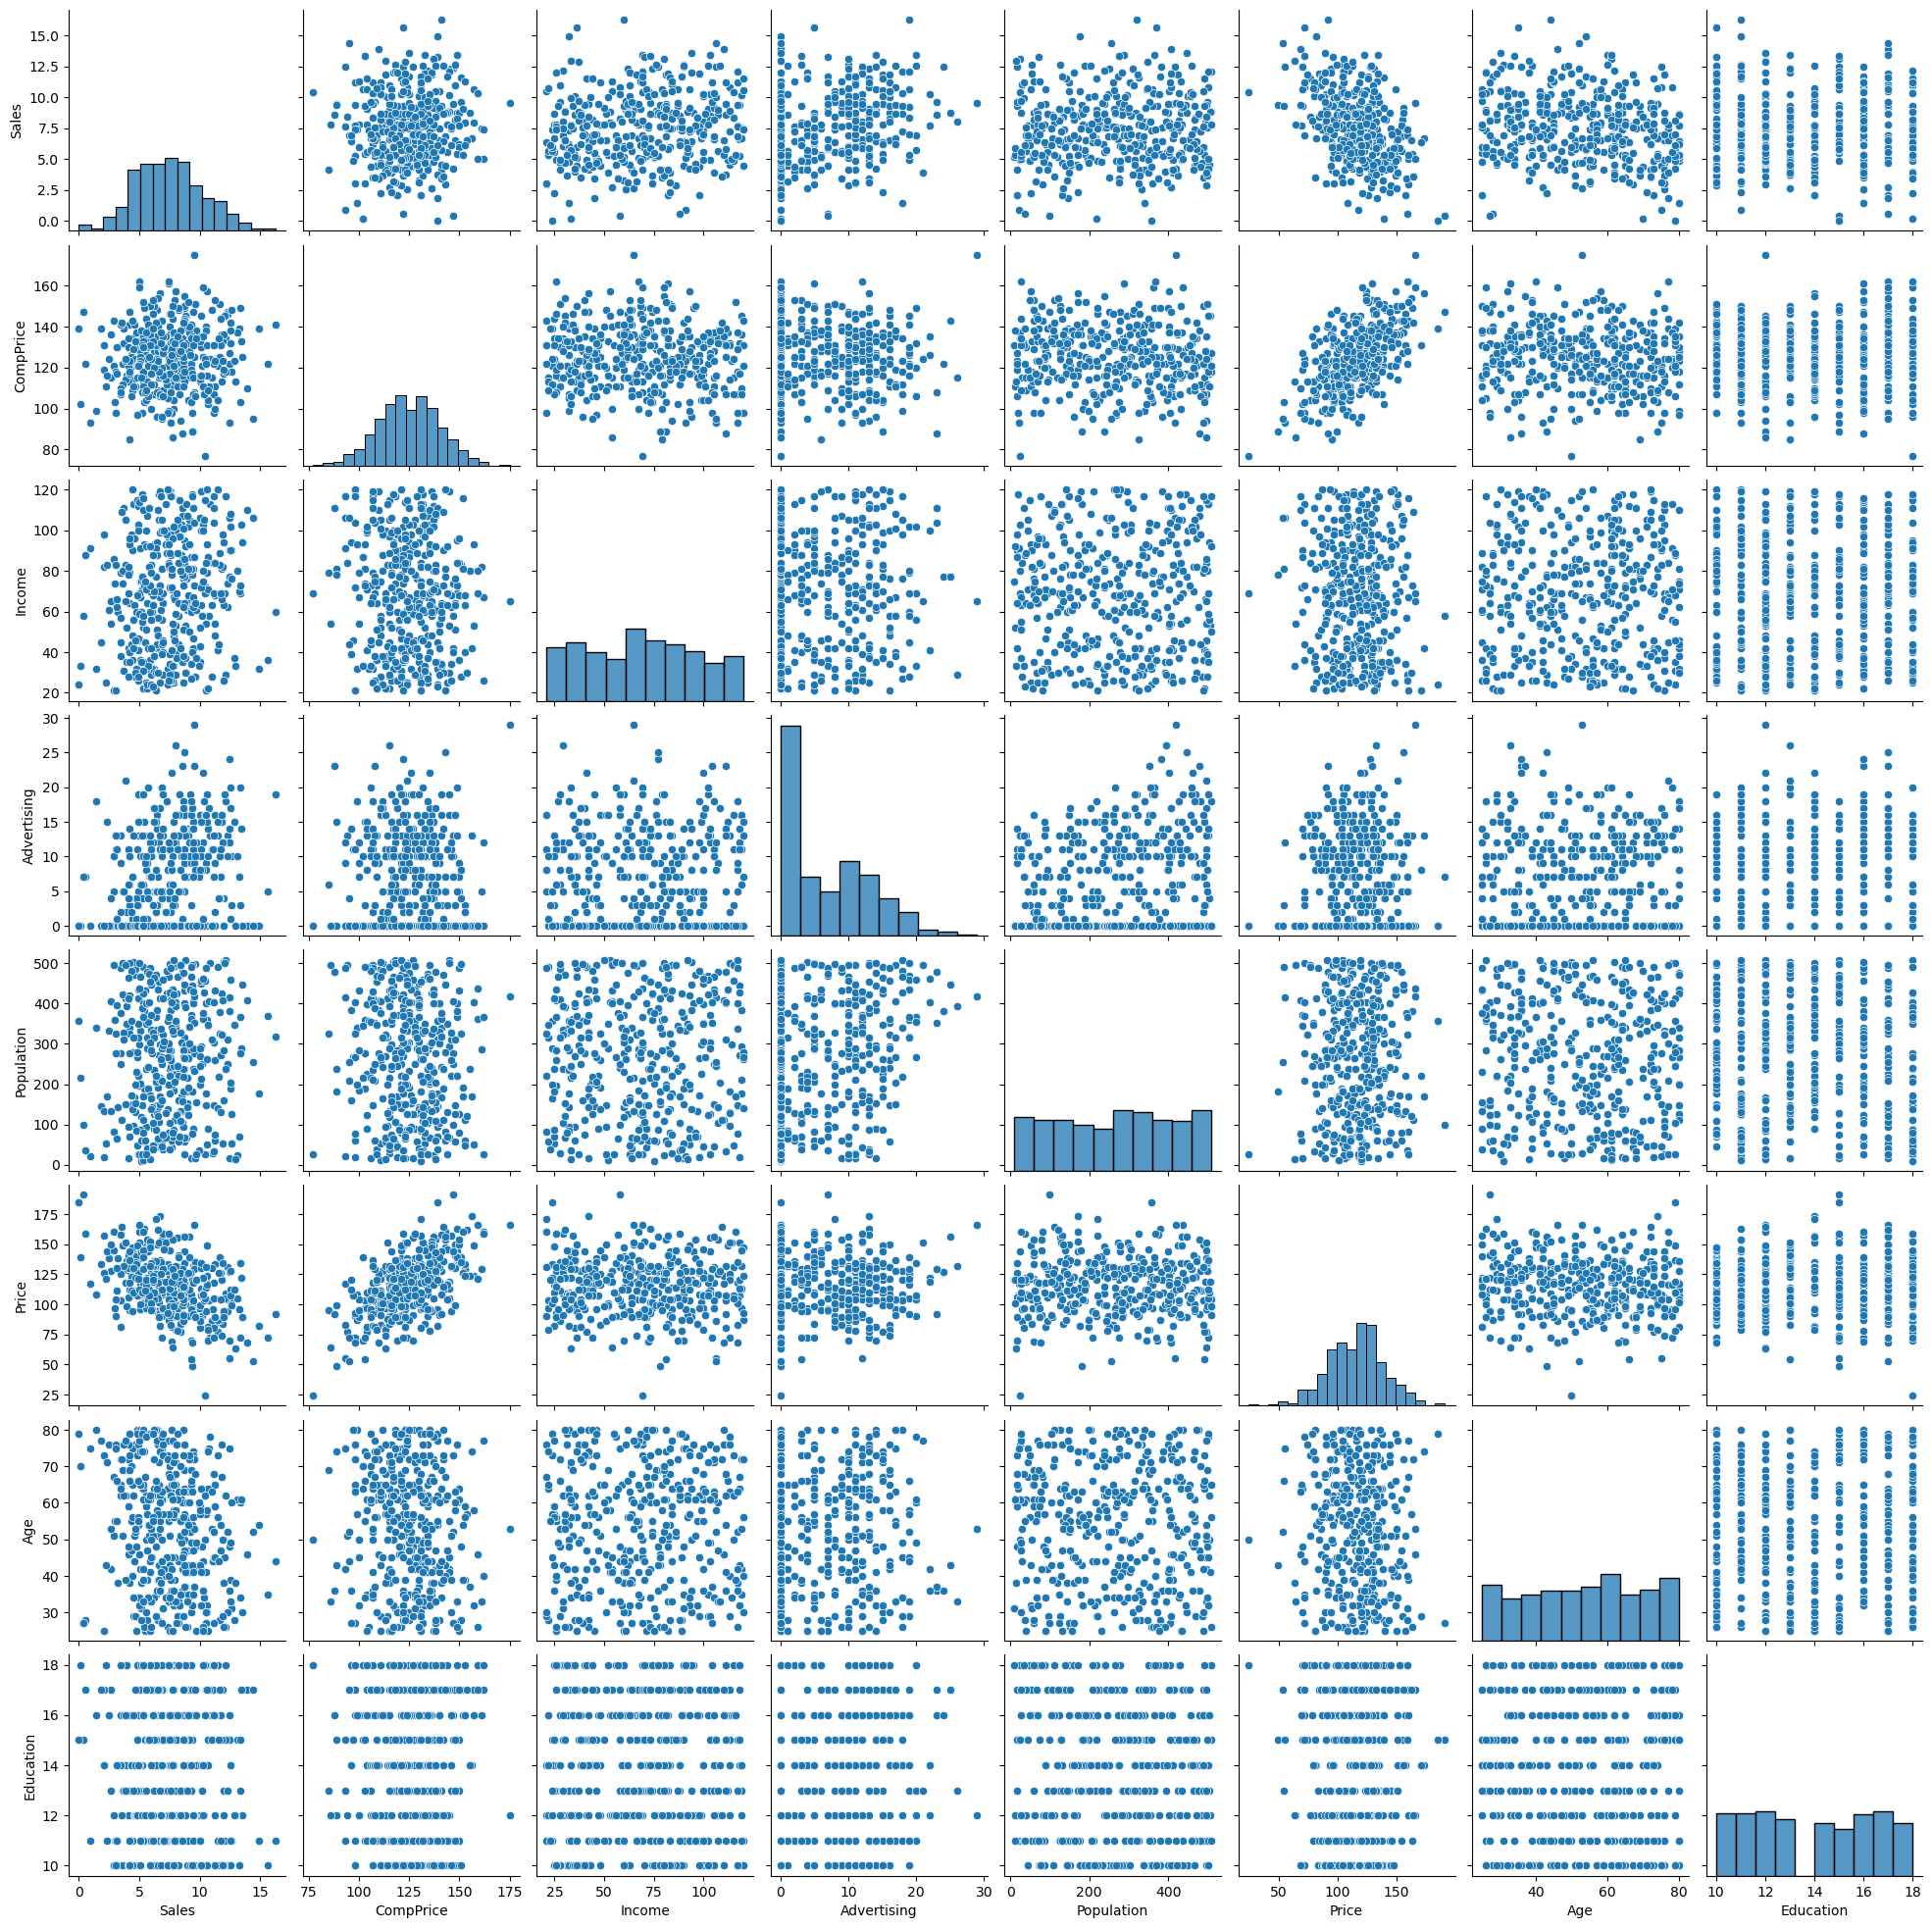

In [42]:
plt.figure(figsize=(20,8))
sns.pairplot(data,palette= 'coolwarm')
plt.show()

<AxesSubplot:>

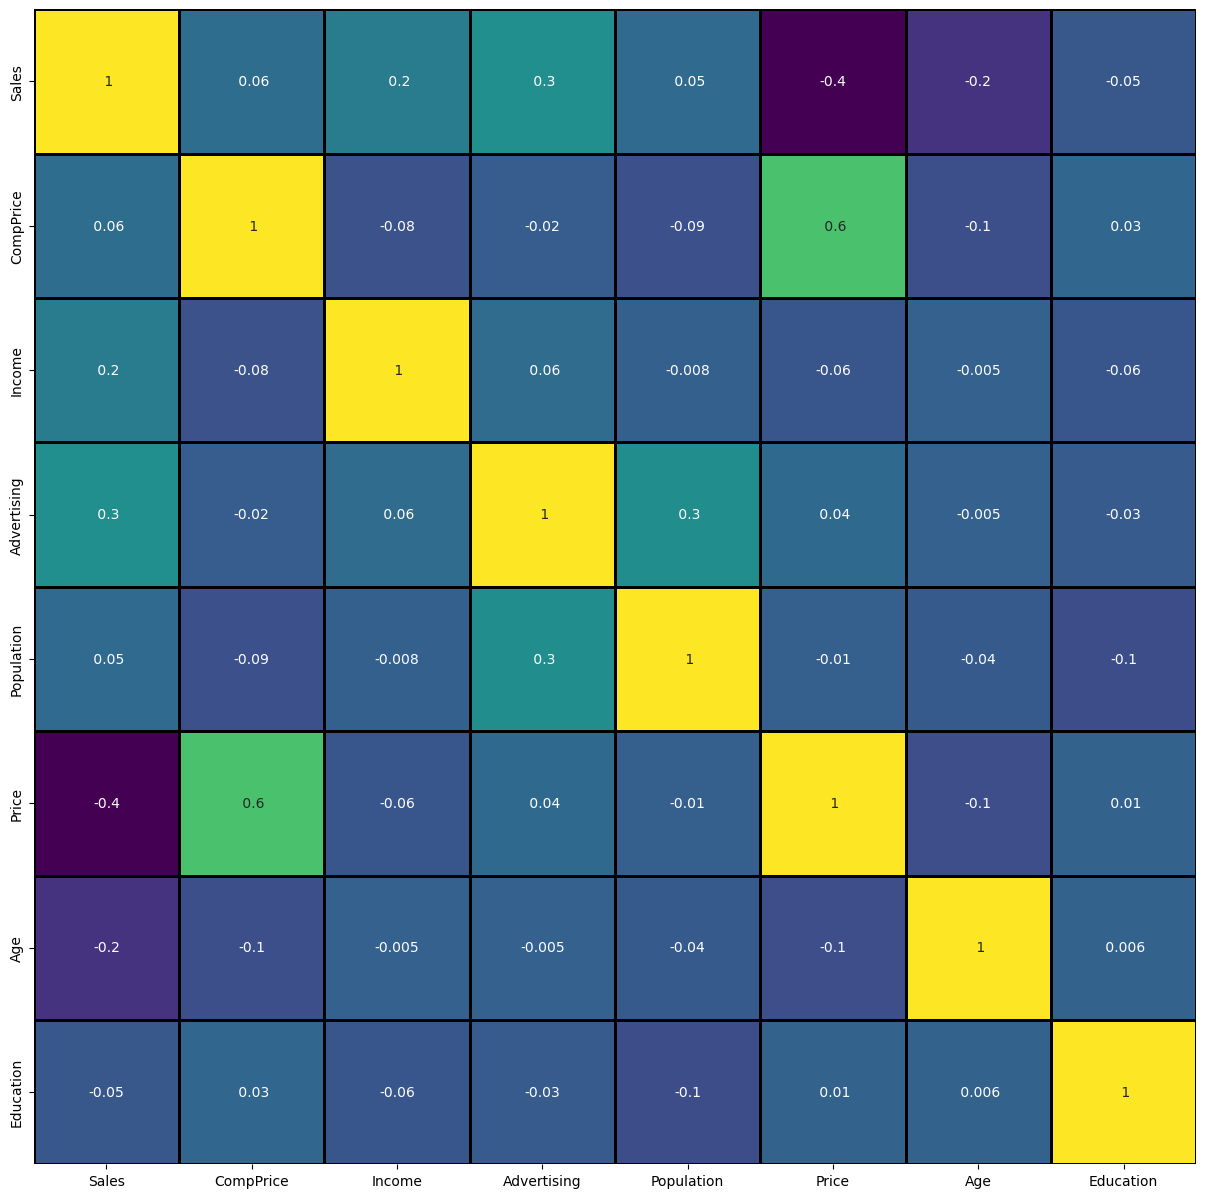

In [44]:
#correlation matrix

fig,ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), annot = True,fmt = ' .1g',cmap = 'viridis',cbar=False,linewidths=0.8,linecolor='black')

Index(['ShelveLoc', 'Urban', 'US', 'Sales_cat'], dtype='object')


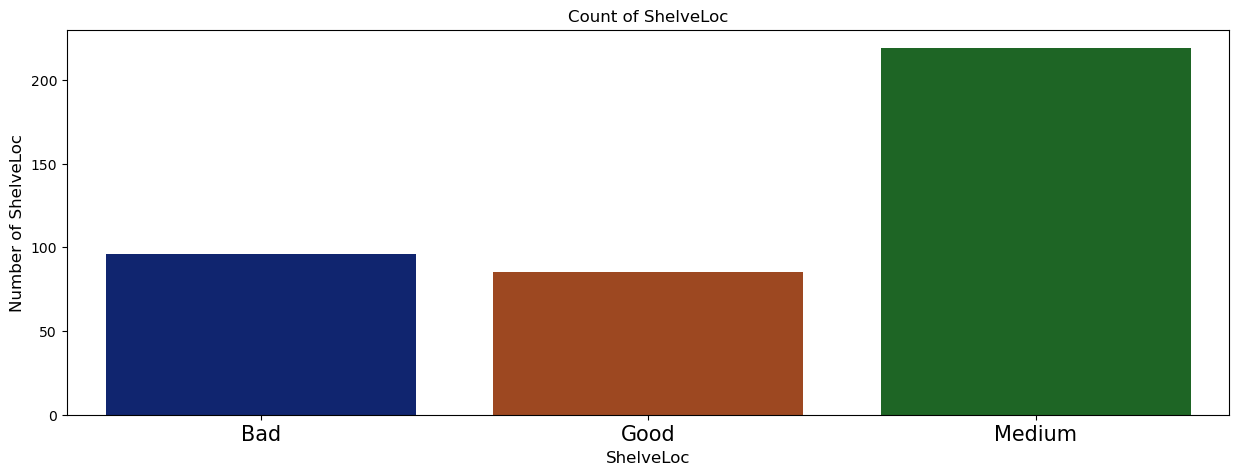

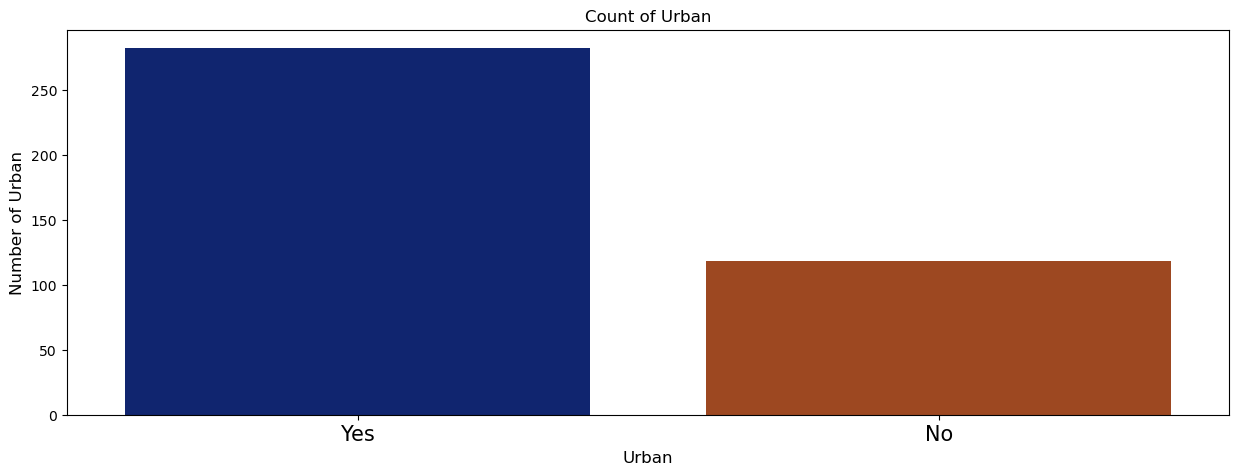

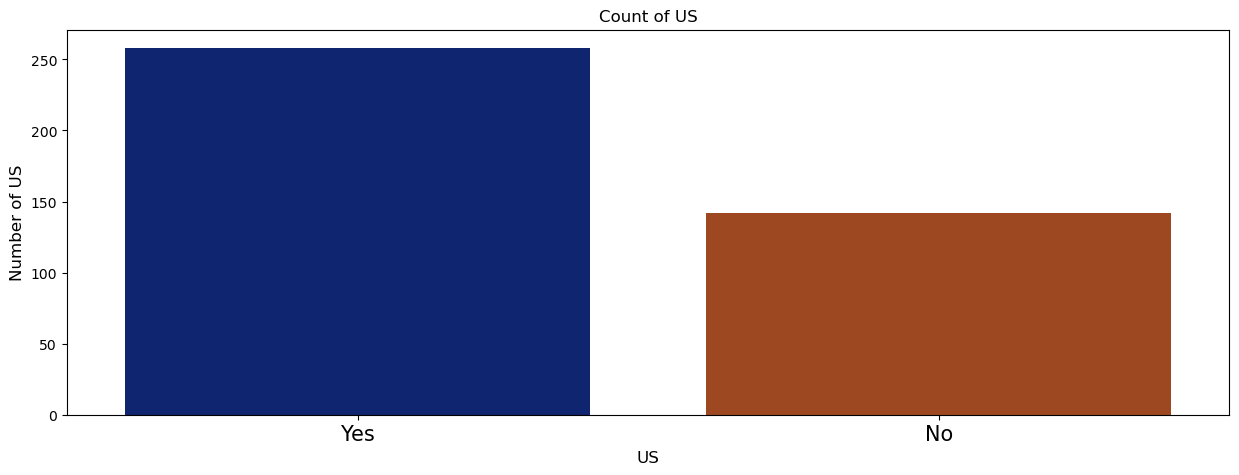

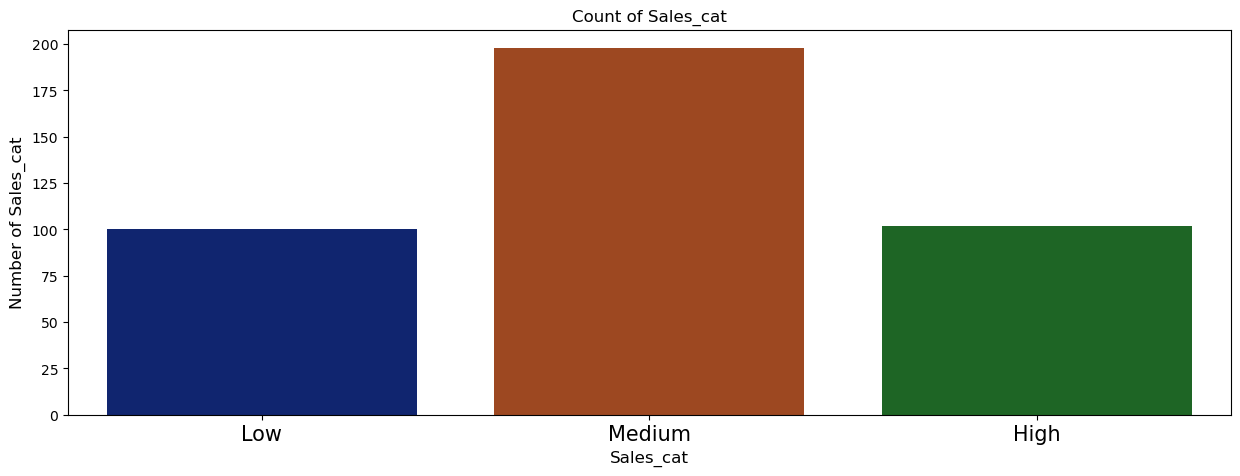

In [46]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = data1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=data1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

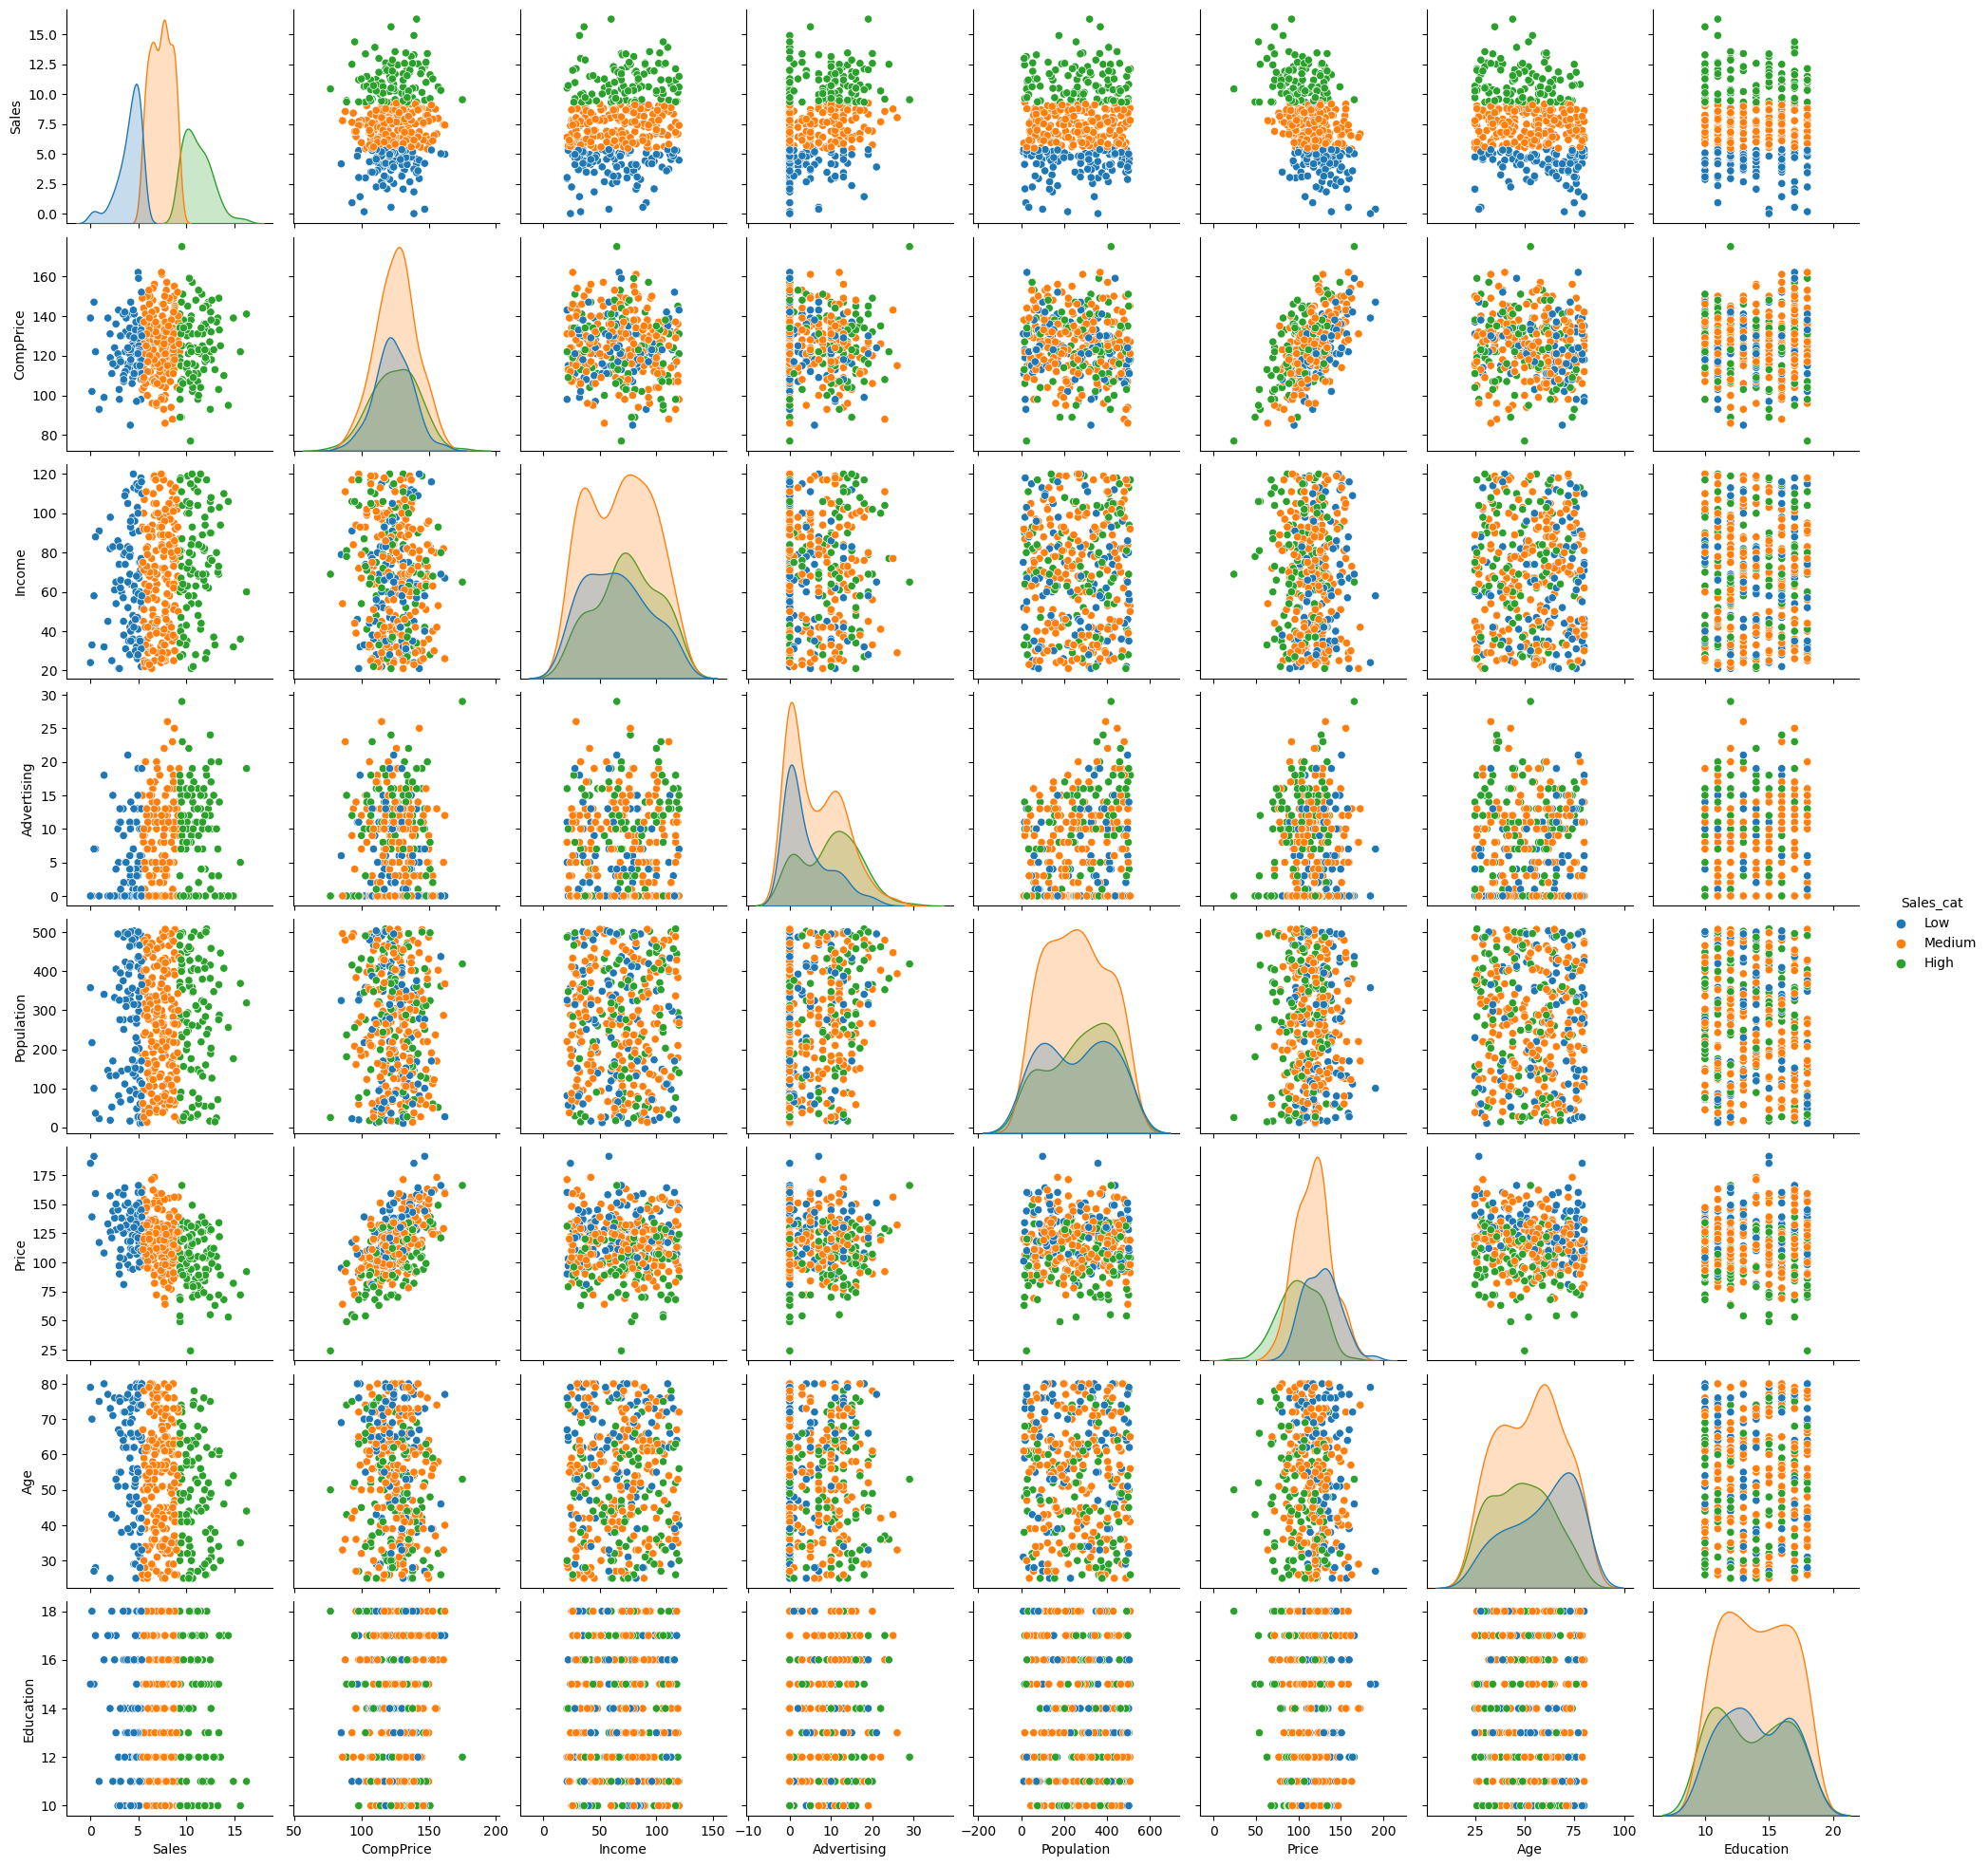

In [47]:
sns.pairplot(data=data1, hue = 'Sales_cat')

In [48]:
data2 = data1.copy()
data2.drop('Sales',axis = 1,inplace=True)
data2 = pd.get_dummies(data2.iloc[:,:-1])
data2.head()

CompPrice  Income  Advertising  Population  Price  ...  ShelveLoc_Medium  Urban_No  Urban_Yes  US_No  US_Yes
0        138      73           11         276    120  ...                 0         0          1      0       1
1        111      48           16         260     83  ...                 0         0          1      0       1
2        113      35           10         269     80  ...                 1         0          1      0       1
3        117     100            4         466     97  ...                 1         0          1      0       1
4        141      64            3         340    128  ...                 0         0          1      1       0

[5 rows x 14 columns]

Text(0.5, 1.0, 'Correlation with Sales \n')

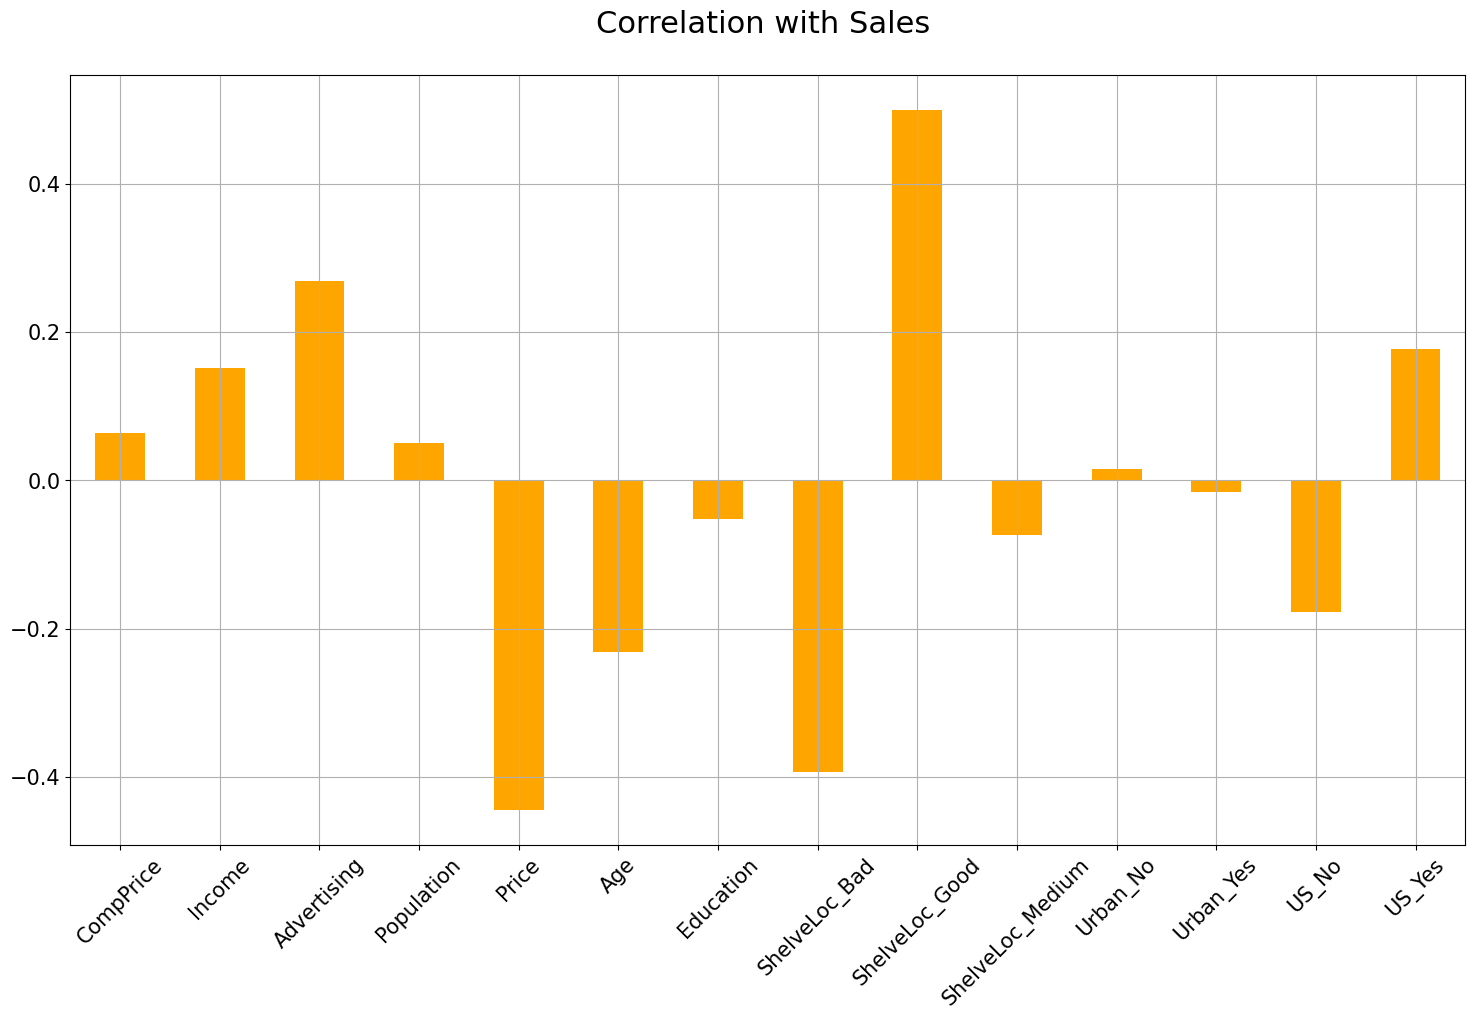

In [50]:
data3 = data2.copy()

correlations = data3.corrwith(data1.Sales)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

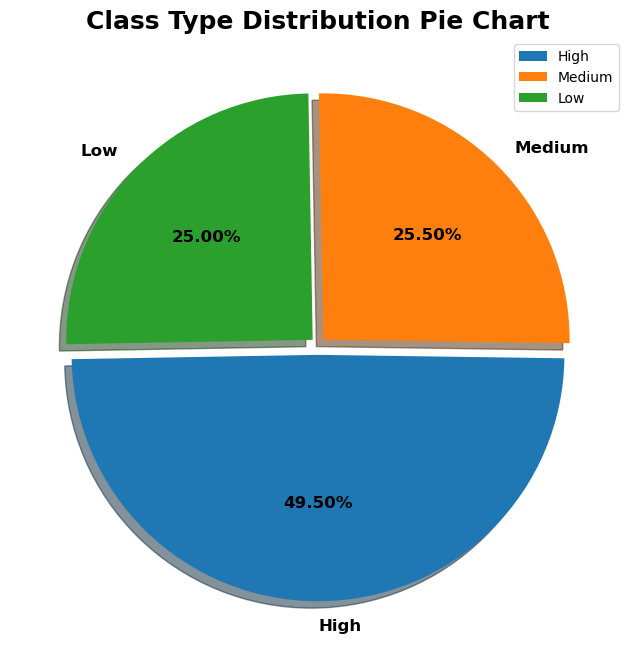

In [51]:
plt.figure(figsize = (12,8))
plt.pie(data1['Sales_cat'].value_counts(),
       labels=data1.Sales_cat.unique(),
       explode = [0.04,0.03,0.03],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 181,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

In [52]:
data1.Sales_cat.value_counts()

Medium    198
High      102
Low       100
Name: Sales_cat, dtype: int64

Text(0.5, 1.0, 'Low Medium or High for Sales')

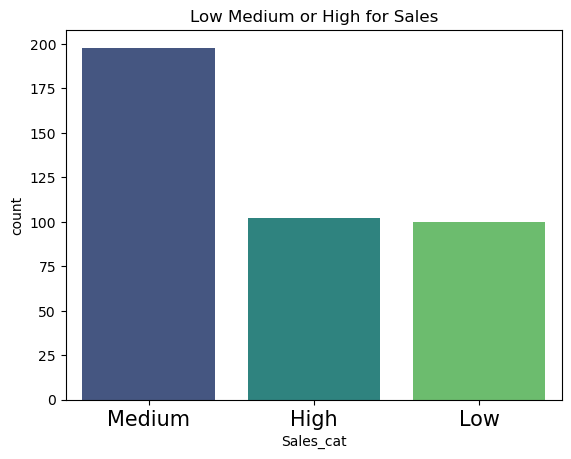

In [53]:
sns.countplot(x = 'Sales_cat',data = data1, palette='viridis',order = data1['Sales_cat'].value_counts().index)
plt.xticks(fontsize = 15)

plt.title('Low Medium or High for Sales')

# Feature Selection Technique

In [56]:
data2 = data1.copy()
data2.drop('Sales',axis = 1,inplace=True)
data2 = pd.get_dummies(data2.iloc[:,:-1])
data2.head()

CompPrice  Income  Advertising  Population  Price  ...  ShelveLoc_Medium  Urban_No  Urban_Yes  US_No  US_Yes
0        138      73           11         276    120  ...                 0         0          1      0       1
1        111      48           16         260     83  ...                 0         0          1      0       1
2        113      35           10         269     80  ...                 1         0          1      0       1
3        117     100            4         466     97  ...                 1         0          1      0       1
4        141      64            3         340    128  ...                 0         0          1      1       0

[5 rows x 14 columns]

In [57]:
data2['Sales'] = data1.Sales_cat
data2.head()

CompPrice  Income  Advertising  Population  Price  Age  ...  ShelveLoc_Medium  Urban_No  Urban_Yes  US_No  US_Yes   Sales
0        138      73           11         276    120   42  ...                 0         0          1      0       1    High
1        111      48           16         260     83   65  ...                 0         0          1      0       1    High
2        113      35           10         269     80   59  ...                 1         0          1      0       1    High
3        117     100            4         466     97   55  ...                 1         0          1      0       1  Medium
4        141      64            3         340    128   38  ...                 0         0          1      1       0     Low

[5 rows x 15 columns]

In [59]:
le = LabelEncoder()
le.fit(data2["Sales"])
data2['Sales'] = le.transform(data2['Sales'])
data2.head()

CompPrice  Income  Advertising  Population  Price  Age  ...  ShelveLoc_Medium  Urban_No  Urban_Yes  US_No  US_Yes  Sales
0        138      73           11         276    120   42  ...                 0         0          1      0       1      0
1        111      48           16         260     83   65  ...                 0         0          1      0       1      0
2        113      35           10         269     80   59  ...                 1         0          1      0       1      0
3        117     100            4         466     97   55  ...                 1         0          1      0       1      2
4        141      64            3         340    128   38  ...                 0         0          1      1       0      1

[5 rows x 15 columns]

In [60]:
#split our variables into x(input) and y(output)

x = data2.iloc[:,:-1]

y = data2.Sales


In [62]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest,chi2

test = SelectKBest(score_func = chi2, k=4)

fit = test.fit(x,y)

In [65]:
scores = fit.scores_

features = fit.transform(x)

In [66]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),columns = ['Score','Feature'])

score_df.sort_values(by = 'Score',ascending=False, inplace=True)
score_df

Score           Feature
4   300.881058             Price
2   251.767458       Advertising
3   141.113336        Population
5   106.577639               Age
8    66.174919    ShelveLoc_Good
1    65.145403            Income
7    48.524460     ShelveLoc_Bad
12   13.109136             US_No
9     8.654770  ShelveLoc_Medium
13    7.215106            US_Yes
0     2.253637         CompPrice
6     0.689685         Education
10    0.163751          Urban_No
11    0.068520         Urban_Yes

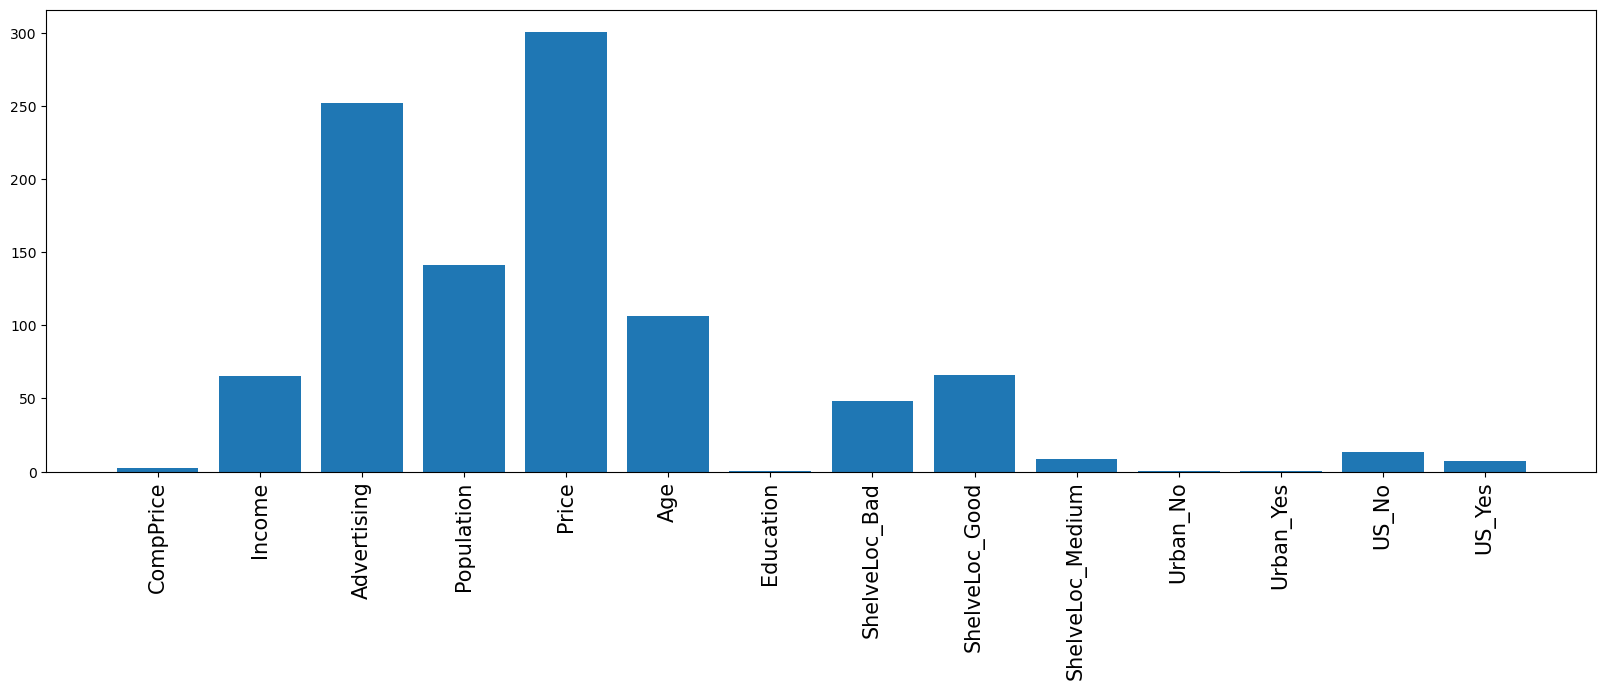

In [68]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

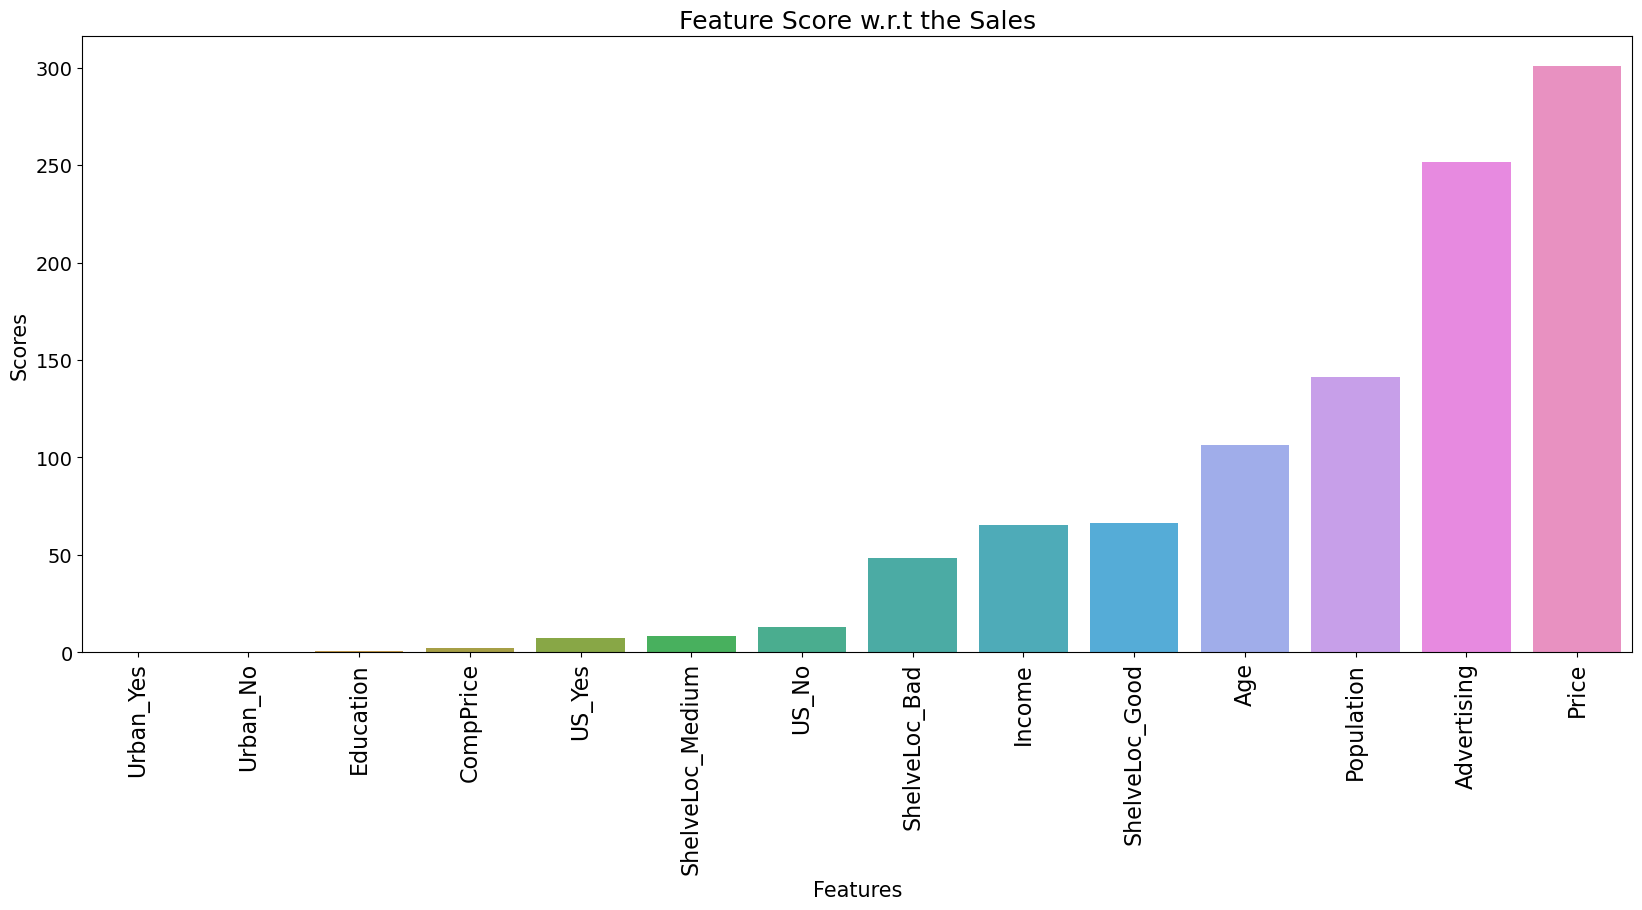

In [69]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [71]:
model_data = data2[['Price', 'Advertising','Population', 'Income', 'Age', 'ShelveLoc_Good', 'ShelveLoc_Bad', 'ShelveLoc_Medium','Sales']]
model_data.head()

Price  Advertising  Population  Income  Age  ShelveLoc_Good  ShelveLoc_Bad  ShelveLoc_Medium  Sales
0    120           11         276      73   42               0              1                 0      0
1     83           16         260      48   65               1              0                 0      0
2     80           10         269      35   59               0              0                 1      0
3     97            4         466     100   55               0              0                 1      2
4    128            3         340      64   38               0              1                 0      1

In [74]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

%time
classifier_rf.fit(x,y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(x,y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

Wall time: 0 ns
checking the oob score 0.635
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.66
RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


Now let’s sort the data with the help of feature importance

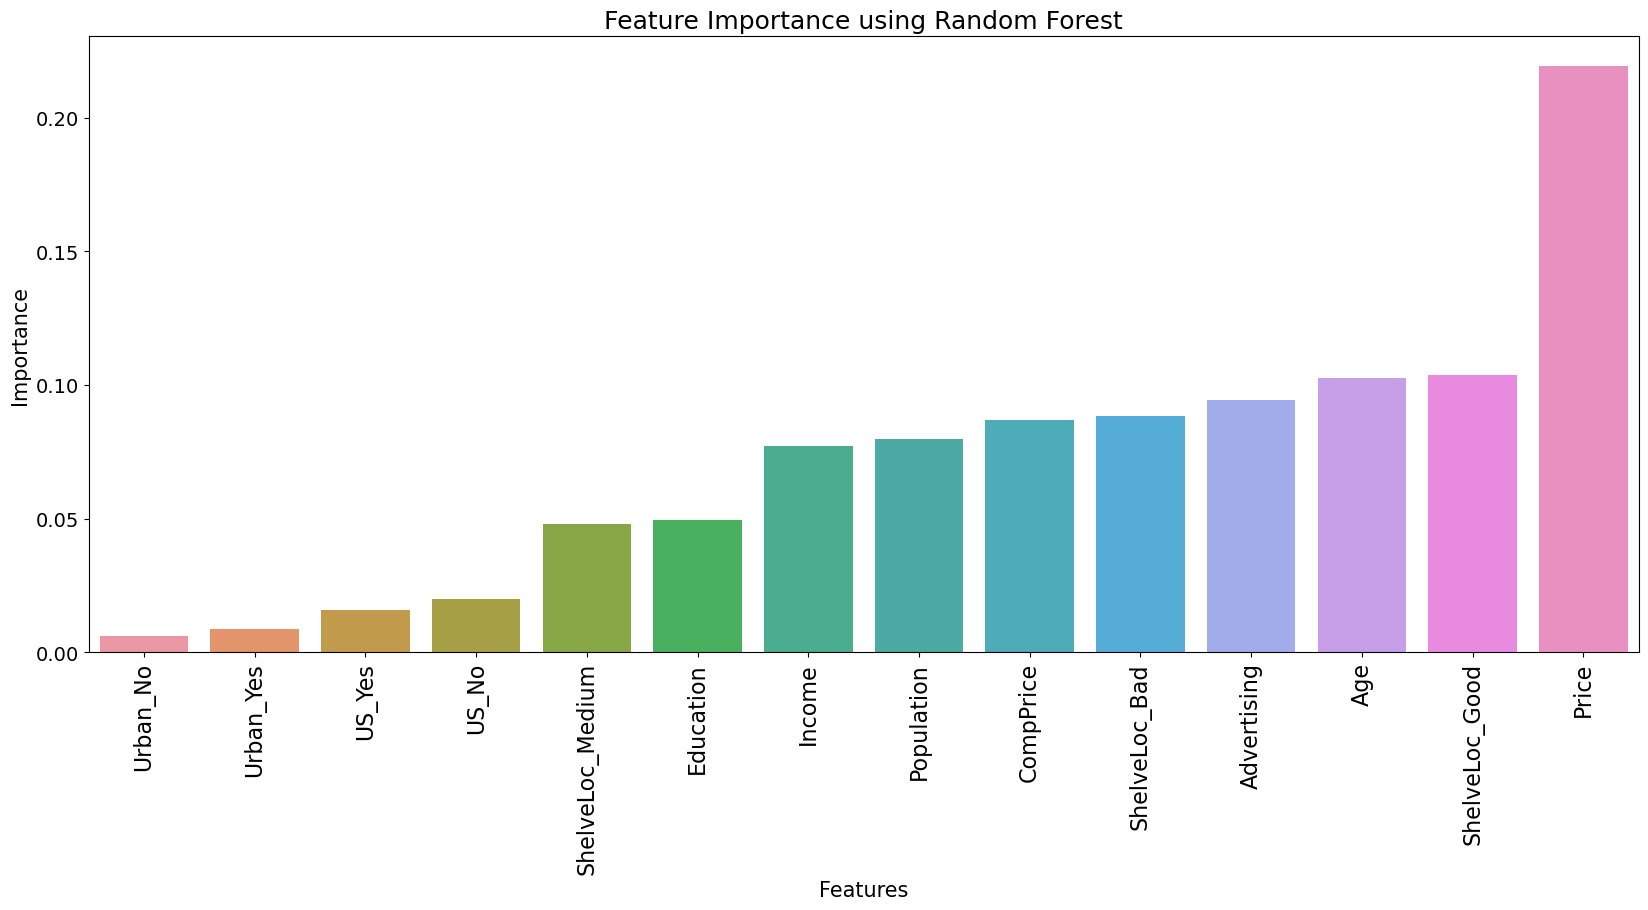

In [76]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": x.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

In [77]:
X = model_data.drop('Sales',axis = 1)
Y = model_data['Sales']

In [78]:
Y.unique()

array([0, 2, 1])

In [79]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(X, Y):
# select rows
    train_X, test_X = X.iloc[train_ix], X.loc[test_ix]
    train_y, test_y = Y.iloc[train_ix], Y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({2: 178, 0: 92, 1: 90}) Testing Data Counter({2: 20, 0: 10, 1: 10})


In [80]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=0,stratify=Y)

In [81]:
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({2: 139, 0: 71, 1: 70}) Testing Data Counter({2: 59, 0: 31, 1: 30})


In [86]:
print("Shape of x_train:",x_train.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test:",y_test.shape)


Shape of x_train: (280, 8)
Shape of x_test: (120, 8)
Shape of y_train: (280,)
Shape of y_test: (120,)


# Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [94]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    92.0  90.0  178.0       1.0      360.0         360.0
_______________________________________________
Confusion Matrix: 
 [[ 92   0   0]
 [  0  90   0]
 [  0   0 178]]

Test Result:
Accuracy Score: 67.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1          2  accuracy  macro avg  weighted avg
precision   0.833333   0.6   0.666667     0.675   0.700000      0.691667
recall      0.500000   0.6   0.800000     0.675   0.633333      0.675000
f1-score    0.625000   0.6   0.727273     0.675   0.650758      0.669886
support    10.000000  10.0  20.000000     0.675  40.00000

# Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [96]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train,y_train)

print_score(rf_clf,x_train,y_train,x_test,y_test,train=True)
print_score(rf_clf,x_train,y_train,x_test,y_test,train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              0     1      2  accuracy  macro avg  weighted avg
precision   1.0   1.0    1.0       1.0        1.0           1.0
recall      1.0   1.0    1.0       1.0        1.0           1.0
f1-score    1.0   1.0    1.0       1.0        1.0           1.0
support    71.0  70.0  139.0       1.0      280.0         280.0
_______________________________________________
Confusion Matrix: 
 [[ 71   0   0]
 [  0  70   0]
 [  0   0 139]]

Test Result:
Accuracy Score: 66.67%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.777778   0.636364   0.633803  0.666667    0.682648      0.671637
recall      0.677419   0.466667   0.762712  0.666667    0.635599      0.666667
f1-score    0.724138   0.538462   0.692308  0.666667    0.651636      0.662069
support    31.000000  30.000000  

# Handling imbalance data using SMOTE based techniques

In [99]:
x = model_data.drop(['Sales'],axis = 1)
y = model_data['Sales']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [100]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of x_train:  (280, 8)
Shape of y_train:  (280,)
Shape of x_test:  (120, 8)
Shape of y_test:  (120,)


# SMOTE Oversampling technique

In [101]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({2: 139, 0: 71, 1: 70})
After Counter({2: 139, 1: 139, 0: 139})


In [102]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({2: 139, 0: 71, 1: 70})
After Counter({1: 140, 2: 139, 0: 139})


In [103]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({2: 139, 0: 71, 1: 70})
After Counter({0: 128, 1: 127, 2: 118})


In [104]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({2: 139, 0: 71, 1: 70})
After Counter({0: 69, 1: 68, 2: 13})


### Performance Analysis after Resampling<a class="anchor" id="7.5"></a> 

In [105]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [106]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [107]:
model_params = {

    'random-forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']

         }
    }
}

In [108]:
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ACTUAL
Confusion Matrix
[[21  0 10]
 [ 0 16 14]
 [ 5  8 46]] 

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        31
           1       0.67      0.53      0.59        30
           2       0.66      0.78      0.71        59

    accuracy                           0.69       120
   macro avg       0.71      0.66      0.68       120
weighted avg       0.70      0.69      0.69       120
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE
Confusion Matrix
[[27  1  3]
 [ 1 21  8]
 [ 9 26 24]] 

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        31
           1       0.44      0.70      0.54        30
           2       0.69      0.41      0.51        59

    accuracy                           0.60       120
   macro avg    

#### As the results can be compared, ADASYN technique gave the best results we are going to use it further 

In [109]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({2: 139, 0: 71, 1: 70})
After Counter({1: 140, 2: 139, 0: 139})


In [110]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train_ada)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Before Counter({1: 140, 2: 139, 0: 139})
After Counter({1: 98, 0: 97, 2: 97})
Shape of X_train:  (292, 8)
Shape of X_test:  (126, 8)
Shape of y_train:  (292,)
Shape of y_test (126,)


### Random Forest hyperparameter tuning

In [111]:
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators= each, random_state= 1)
    rf_loop.fit(x_train,y_train)
    
    score_array.append(rf_loop.score(x_test,y_test))

In [112]:
loc = np.array(score_array).max()
score_array.index(loc)+1

42

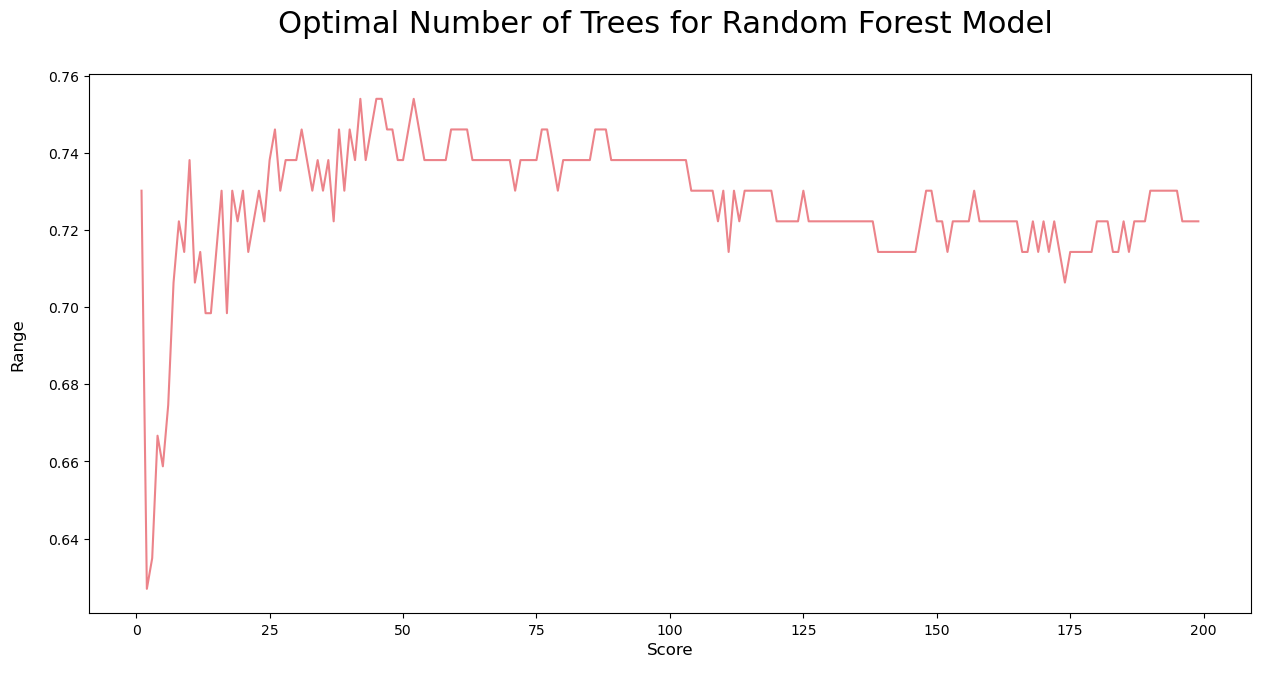

In [113]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Randomized Search Cross Validation

In [114]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 195, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True})


In [115]:
rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 92.47%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.958333   0.888889   0.931818  0.924658    0.926347      0.926219
recall      0.948454   0.979592   0.845361  0.924658    0.924469      0.924658
f1-score    0.953368   0.932039   0.886486  0.924658    0.923964      0.923992
support    97.000000  98.000000  97.000000  0.924658  292.000000    292.000000
_______________________________________________
Confusion Matrix: 
 [[92  1  4]
 [ 0 96  2]
 [ 4 11 82]]

Test Result:
Accuracy Score: 72.22%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1          2  accuracy   macro avg  weighted avg
precision   0.829268   0.714286   0.611111  0.722222    0.718222      0.718222
recall      0.809524   0.833333   0.523810  0.722222    0.722222      0.722222
f1-score    0.819277   0.769231   0.564103  0.7

### Visualizing one of the decision tree in random forest

In [116]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, min_samples_leaf=4, n_estimators=195,
                       random_state=42)

In [117]:
data1.Sales_cat.unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low' < 'Medium' < 'High']

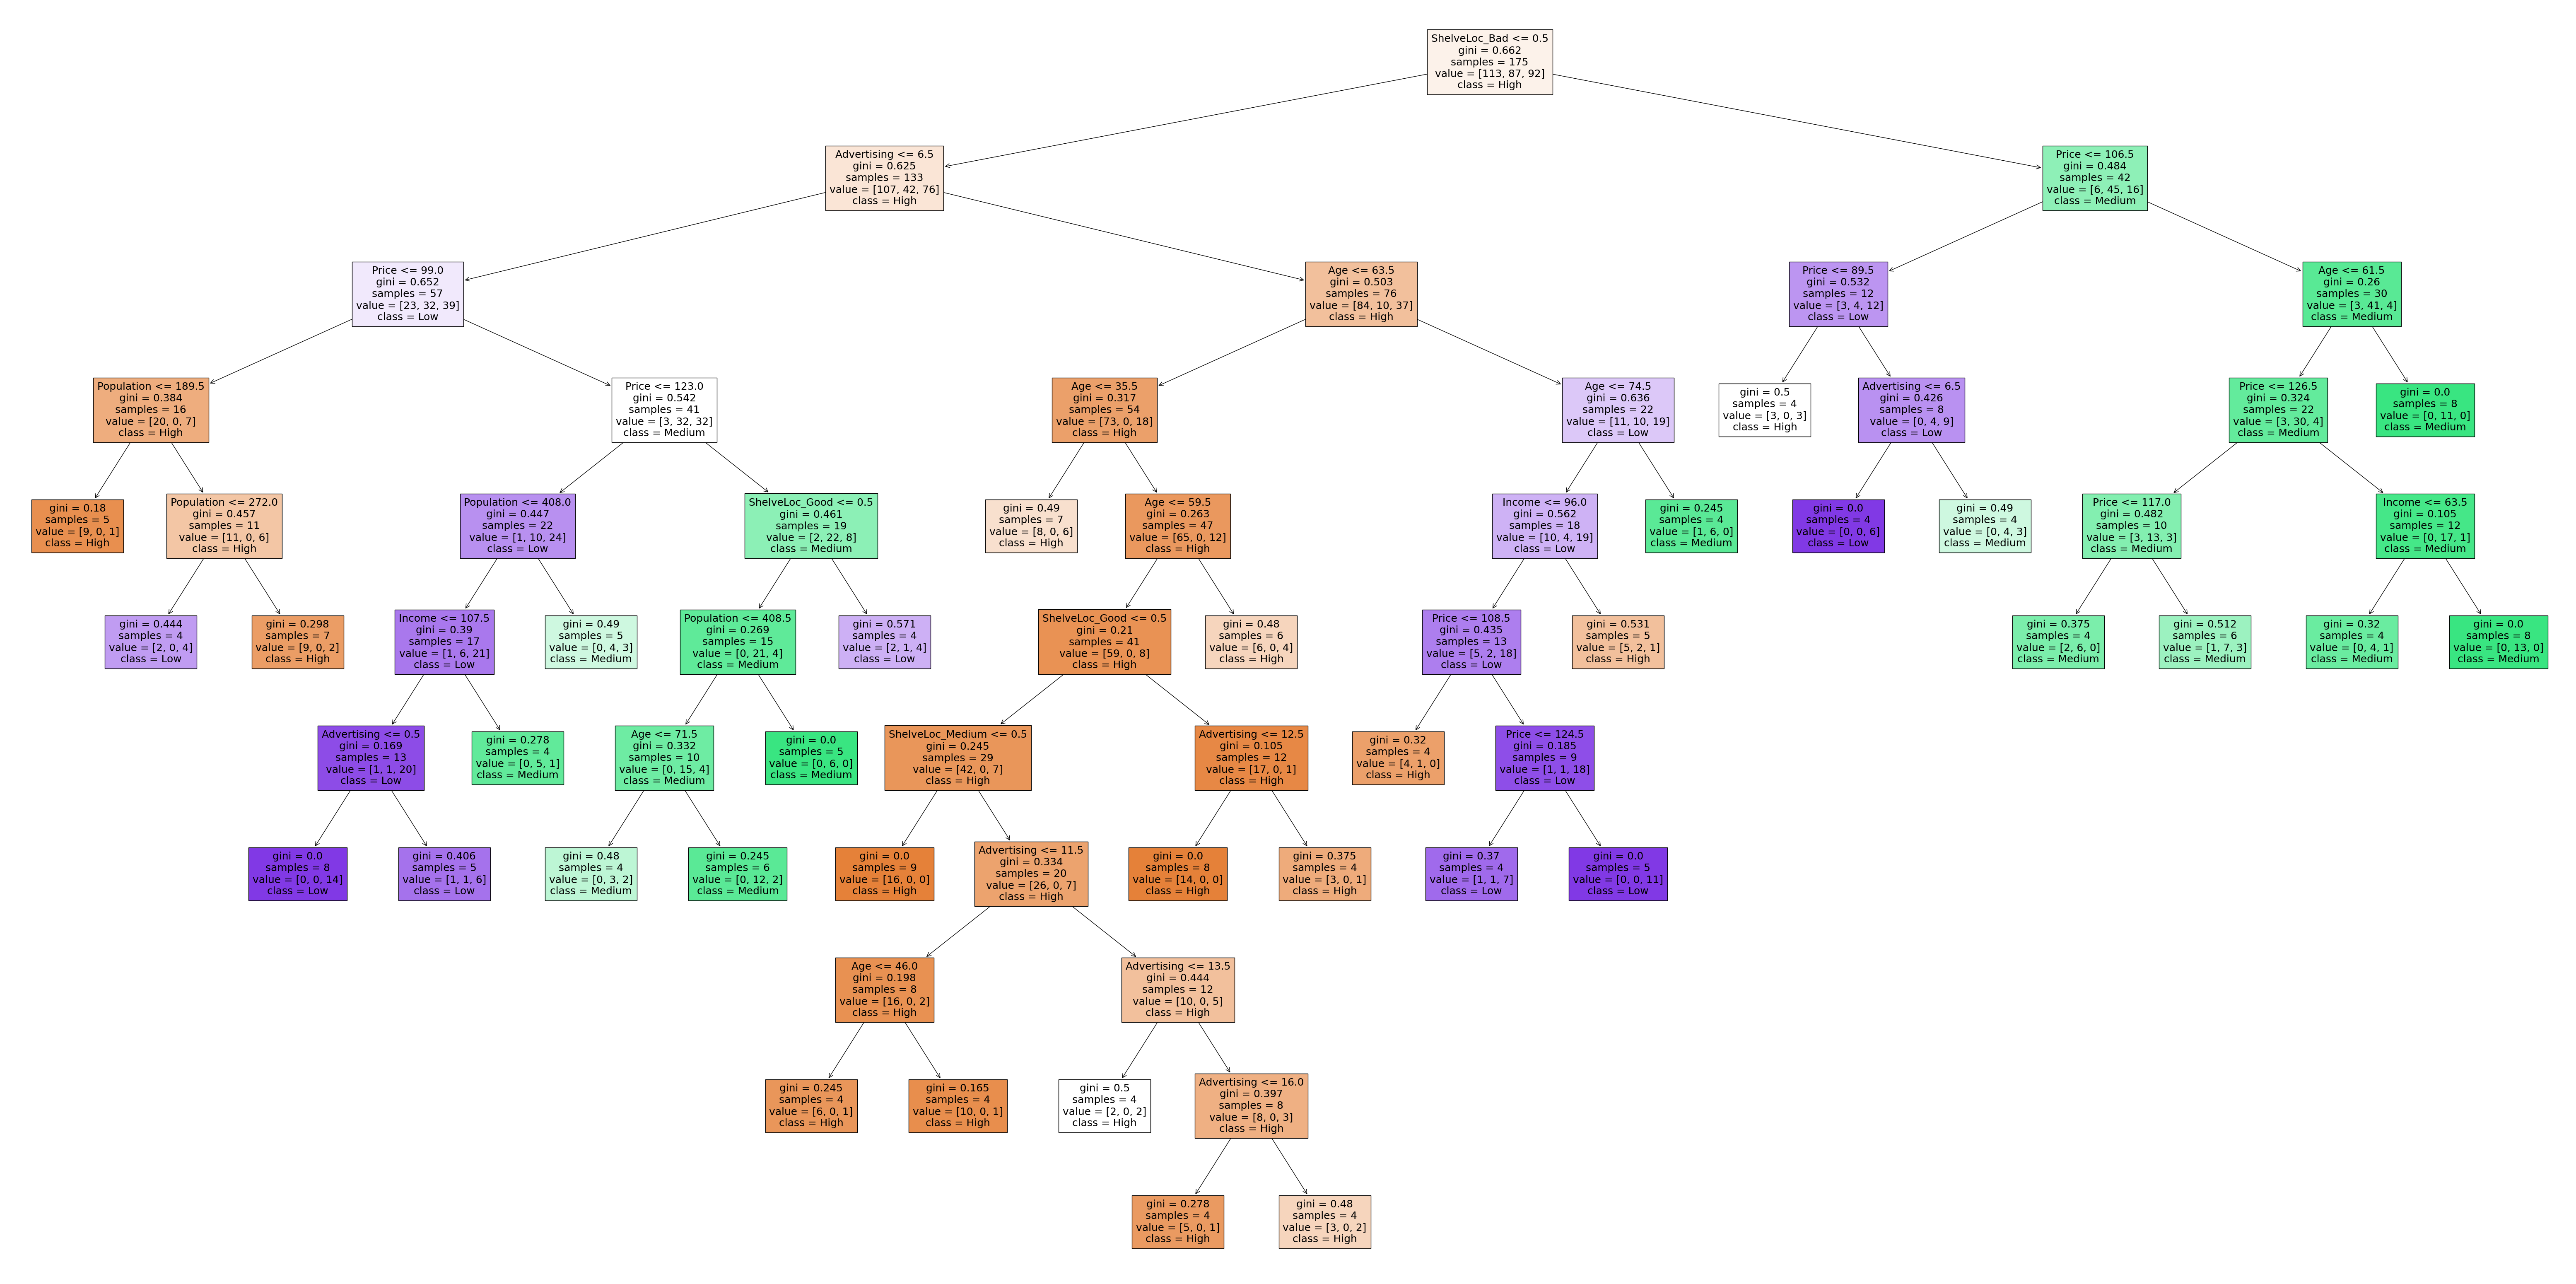

In [126]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[190],feature_names=model_data.columns,class_names=data1.Sales_cat.unique(),filled = True)
plt.show()